## **Python for Quantitative Trading: Futures**
### **Integrated CTA Strategies Episode 2 - Construct Factors**

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fir Sept 03 15:28:01 2021

@author: Bradley

Slides for practicing CTA Strategies
"""

'\nCreated on Fir Sept 03 15:28:01 2021\n\n@author: Bradley\n\nSlides for practicing CTA Strategies\n'

In [2]:
import numpy as np
import pandas as pd
import math
import gzip
import _pickle as cPickle
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

import os
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
import dask
from dask import compute, delayed
reload(helper)
reload(stats)

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号


c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
HEAD_PATH = r"E:\My_Strategies_CTA" 
DATA_PATH = HEAD_PATH + "\\pkl_tick" 
NIGHT_PATH = HEAD_PATH + "\\night_pkl_tick\\"
SAVE_PATH = r"E:\My_Strategies_CTA"  #保存计算的因子数据的地方
SIGNAL_PATH = r"E:\My_Strategies_CTA" 
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

In [4]:
product_list = ["rb", "hc", "i", "j", "jm"]
product = product_list[1] #随便取一个商品期货，可以更改
print(product)
all_dates = list(map(lambda x: x, os.listdir(DATA_PATH + "\\" + product)))
print(len(all_dates), all_dates[:6])
n_days = len(all_dates)

hc
1067 ['20170103.pkl', '20170104.pkl', '20170105.pkl', '20170106.pkl', '20170109.pkl', '20170110.pkl']


In [5]:
# 遍历下所有的日期的数据做一个检验，检验是否处理过涨跌停
for date in all_dates:
    data = load(DATA_PATH + '\\' + product +"\\"+date[:8] + ".pkl")
    if (sum((data["next.bid"]==0) | (data["next.ask"]==0)>10)):
        print(date)

In [6]:
# 取一天的数据读取出来
date = all_dates[1][:8] #随便取一天，可以更改
print(date)
data = load(DATA_PATH + '\\' + product +"\\" + date + ".pkl") 
display(data)

20170104


,contract,date.time,price,cum.open.int,open.int,turnover,qty,bid,ask,bid.qty,ask.qty,date,time,milli,good,mid.price,buy.trade,buy2.trade,sell.trade,sell2.trade,log.price,ret,wpr,wpr.ret,next.ask,next.bid,min.1024,max.1024,min.2048,max.2048,min.4096,max.4096
0,hc1705,2017-01-03 20:59:00.500,3305.0,365016,4,1784700.0,54,3305.0,3307.0,13,1,20170103,20:59:00,500,False,3306.0,27.0,0.0,27.0,0.0,8.103754,0.002682,3306.857143,8.857143,3305.0,3303.0,3306.857143,3306.857143,3306.857143,3306.857143,3306.857143,3306.857143
1,hc1705,2017-01-03 21:00:00.500,3305.0,365044,28,2644820.0,80,3303.0,3305.0,4,10,20170103,21:00:00,500,False,3304.0,41.0,0.0,39.0,0.0,8.102759,-0.000994,3303.571429,-3.285714,3305.0,3300.0,3303.571429,3306.857143,3303.571429,3306.857143,3303.571429,3306.857143
2,hc1705,2017-01-03 21:00:01.000,3300.0,365074,30,4425360.0,134,3300.0,3305.0,9,5,20170103,21:00:01,0,False,3302.5,0.0,0.0,68.0,66.0,8.102651,-0.000108,3303.214286,-0.357143,3304.0,3302.0,3303.214286,3306.857143,3303.214286,3306.857143,3303.214286,3306.857143
3,hc1705,2017-01-03 21:00:01.500,3304.0,365064,-10,1321280.0,40,3302.0,3304.0,2,2,20170103,21:00:01,500,False,3303.0,8.0,0.0,32.0,0.0,8.102586,-0.000065,3303.000000,-0.214286,3308.0,3302.0,3303.000000,3306.857143,3303.000000,3306.857143,3303.000000,3306.857143
4,hc1705,2017-01-03 21:00:02.000,3301.0,365036,-28,1454040.0,44,3302.0,3308.0,40,120,20170103,21:00:02,0,False,3305.0,16.0,28.0,0.0,0.0,8.102738,0.000151,3303.500000,0.500000,3304.0,3302.0,3303.000000,3306.857143,3303.000000,3306.857143,3303.000000,3306.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70347,hc1705,2017-01-05 14:59:58.500,3359.0,368138,2,201580.0,6,3358.0,3362.0,118,3,20170105,14:59:58,500,False,3360.0,4.0,0.0,2.0,0.0,8.120262,0.000640,3361.900826,2.150826,3363.0,3362.0,3359.152542,3402.914894,3359.152542,3407.634146,3359.152542,3407.634146
70348,hc1705,2017-01-05 14:59:59.000,3362.0,368138,0,201720.0,6,3362.0,3363.0,1,7,20170105,14:59:59,0,False,3362.5,6.0,0.0,0.0,0.0,8.120328,0.000067,3362.125000,0.224174,3363.0,3360.0,3359.152542,3402.914894,3359.152542,3407.634146,3359.152542,3407.634146
70349,hc1705,2017-01-05 14:59:59.500,3363.0,368138,0,134500.0,4,3360.0,3363.0,4,6,20170105,14:59:59,500,False,3361.5,2.0,0.0,2.0,0.0,8.120053,-0.000275,3361.200000,-0.925000,3359.0,3358.0,3359.152542,3402.914894,3359.152542,3407.634146,3359.152542,3407.634146
70350,hc1705,2017-01-05 15:00:00.000,3358.0,368132,-6,940720.0,28,3358.0,3359.0,112,56,20170105,15:00:00,0,False,3358.5,0.0,0.0,20.0,8.0,8.119299,-0.000754,3358.666667,-2.533333,3359.0,3358.0,3358.666667,3402.914894,3358.666667,3407.634146,3358.666667,3407.634146


[Text(-10000.0, 0, '2017-01-03 20:59:00.500'),
 Text(0.0, 0, '2017-01-03 21:00:00.500'),
 Text(10000.0, 0, '2017-01-03 21:00:01.000'),
 Text(20000.0, 0, '2017-01-03 21:00:01.500'),
 Text(30000.0, 0, '2017-01-03 21:00:02.000'),
 Text(40000.0, 0, '2017-01-03 21:00:02.500'),
 Text(50000.0, 0, '2017-01-03 21:00:03.000'),
 Text(60000.0, 0, '2017-01-03 21:00:03.500'),
 Text(70000.0, 0, '2017-01-03 21:00:04.000'),
 Text(80000.0, 0, '2017-01-03 21:00:04.500')]

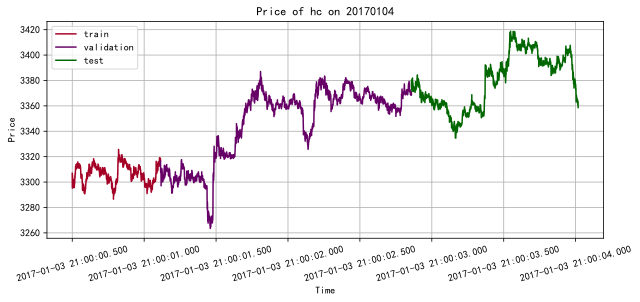

In [7]:
# 画wpr价格图，同时叠加画上good=True部分的图并用另一种颜色，表明这部分数据用来回测，前面用来因子预热，后面用来未来函数
data1 = data[(data['good'] == False) & (data['date'] < date)]
data2 = data[data['good'] == True]
data3 = data[(data['good'] == False) & (data['date'] > date)]
# 下面的ax是dataframe.plot参数，并不是pyplot.plt的画布
ax = data1[['wpr']].plot(rot=15, colormap='RdYlBu',label='train', legend=True, figsize=(10,4), xlabel='Time', ylabel='Price', title='Price of %s on %s'%(product,date), grid=True)
data2[['wpr']].plot(ax=ax, rot=15, color='#660066', label='validation', legend=True, figsize=(10,4), grid=True)
data3[['wpr']].plot(ax=ax, rot=15, color='#006600', label='test', legend=True, figsize=(10,4), grid=True)
ax.legend(['train', 'validation', 'test'])
# 把时间画到x轴的方法，第一个就是对一个dataframe去plot然后把date设置成index，另一个就是直接plot序列然后一步set_xticklabels即可
ax.set_xticklabels(data['date.time'])

**开始搭建因子**

秒创文件夹：os.makedirs(path, exist_ok=True)

In [8]:
# 先尝试4096天作为因子取period的参数
period = 4096

# 创建因子值存储的路径
# exist_ok=True则如果已有路径不会报错，否则会报错
for product in product_list:
    os.makedirs(HEAD_PATH + "\\factor_pkl\\" + product, exist_ok=True)

# helper.py中有该函数的定义，当分子or分母为0时，返回0
# np.divide的好处就是分母是0的时候不会报错
def zero_divide(x, y):
    # 去处warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
    return res

**第一个因子：total.trade.imbalance总交易不平衡**
- 该因子相当于是总共的主动买量减去总共的主动卖量，计算一个**成交数据**的成交不平衡，注意这里buy2和sell2不是买二卖二而是非买一卖一的主动买卖量，而且这个主动买卖量也是从成交数据trade里面看谁发起的1或-1给求和算出来的，然后和orderbook的分笔数据做了一个merge，就算是估算出来的也是一个很难得的数据，之前我们也学习过估算的方法
- 主动买量和主动卖量是非常珍贵的数据，即使没有也应自己估算
- 然后结合这样的成交不平衡，做了一个EWMA，他是自己写的EWMA，自己定义的参数是半衰期，不是平常的span/alpha/com，半衰期就是用的类似1024，2048，4096，是一个参数
- 既然是imbalance，**别忘了所有的“不平衡”因子的都是要除以总量**，保证范围在-1到1之间，起到一个标准化的作用，因此计算差值的EWMA后要除以总成交量（qty）的一个相同period下的EWMA，同时做了防止分母为零的一个处理，还需要去除因子的异常值，也就是把所有绝对值大于1的因子值都设置为零，这个函数在helper里面定义了，叫做vanish_thre，保证严谨

In [9]:
# 构建因子total.trade.imbalance
class factor_total_trade_imb_period(factor_template):
    factor_name = "total.trade.imb.period"
    
    # np.power(2, range(12,13)): 4096
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    # overwrite父类的formula代码
    def formula(self, data, period):
        # vanish_thre(x, thre)去处outlier，绝对值大于threshold都设置为0
        return vanish_thre(zero_divide(ewma(data["buy.trade"]+data["buy2.trade"]-data["sell.trade"]-data["sell2.trade"], period, adjust=True), 
                           ewma(data["qty"], period, adjust=True)) ,1).values

In [10]:
x1 = factor_total_trade_imb_period()
# 定义了一个创建文件夹的函数，创建第一个因子文件夹：total.trade.imb
for product in product_list:
    create_signal_path(x1, product, SAVE_PATH)

E:\My_Strategies_CTA\factor_pkl\rb\total.trade.imb.4096
E:\My_Strategies_CTA\factor_pkl\hc\total.trade.imb.4096
E:\My_Strategies_CTA\factor_pkl\i\total.trade.imb.4096
E:\My_Strategies_CTA\factor_pkl\j\total.trade.imb.4096
E:\My_Strategies_CTA\factor_pkl\jm\total.trade.imb.4096


**因子计算**

In [11]:
%%time
# 保存因子计算数值到total.trade.imb
for product in product_list:
    # 常用list套map组合获取包含所有文件名的一个list
    file_list = list(map(lambda x: DATA_PATH+"\\" + product+"\\"+x, os.listdir(DATA_PATH + '\\' + product)))
    # parLapply是我们之前的定义的使用disk并行的函数，并行对象为build_composite_signal，其余参数传入给functools的partial部分，x1是要计算的因子
    parLapply(CORE_NUM, file_list, build_composite_signal, signal_list=x1, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 2min 39s


**检验因子时序平稳性**

In [12]:
import statsmodels.tsa.stattools as ts
import math

# 每隔10个取一个，并且计算的是所有产品所有时间的
to_choose = np.where(np.mod(range(n_days),10)==0)
signal_name = "total.trade.imb.4096"
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file)
        S = load(HEAD_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1,len(all_signal)+1)% period==0]
    result = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product, "adf", result)
    result = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product, "kpss", result)

rb adf (-8.983613186635019, 3.9525881945159214e-13, 10, 1030, {'1%': -3.967586336363062, '5%': -3.414761083092117, '10%': -3.12956401143195})
rb kpss (0.36679793162461527, 0.09146640878249342, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
hc adf (-8.175544427552193, 2.807229221369451e-11, 9, 908, {'1%': -3.968775034237756, '5%': -3.4153362627493324, '10%': -3.1299023676565345})
hc kpss (0.16498518745737487, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
i adf (-7.891940127281681, 1.2700977372295808e-10, 9, 960, {'1%': -3.96823131048697, '5%': -3.4150731893061885, '10%': -3.129747617526584})
i kpss (0.4510111280208425, 0.055167617232395494, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
j adf (-7.551292992072713, 7.765553522475058e-10, 9, 819, {'1%': -3.9698664720718986, '5%': -3.4158642376222073, '10%': -3.1302129130584624})
j kpss (0.34453346101682963, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
jm adf (-7.6711173897677

**创建第二个因子：trade.imbalance，第一个是total.trade.imbalance**
- 顾名思义，第一个是总成交不平衡，因此计算中考虑了非买一卖一的主动买卖量，而这里就仅考虑卖一和买一的主动买卖量，使用主动买一量减去主动卖一量，因为是imbalance signal所以要除以二者的和保证范围在-1到1之间
- 这个计算方式简直和最初版的OBI一模一样，不过这用的是trade的数据，因为是主动买卖量，然后对这个指标做一个EWMA，相当于衍生指标，牛逼
- 当然，**最大的一个区别还是这里的trade imbalance是先除法再算均线，而之前那个是分子分母分别均线再算除法**

- **结果表明trade.imbalance效果要好很多，也就是先算除法，然后再去对整体移动平均**，可能的解释是不同时间的成交量的意义不同，不能直接做加减法（算EWMA）。**而先做除法相当于先标准化了，再取做均线的加减法更有意义**。其实也很好理解，第二种就是每个tick算一个OBI，然后计算OBI的均线，这显然更合理。而第一个是分子分母分别算均线，那不同时期的成交量做移动平均就不是很make sense。
- 结论：**以后涉及到加减法和除法混合的因子可以先做除法再去算rolling，就相当于把rolling看成一种单纯的衍生指标的计算，而不能去影响数据本身**

In [13]:
class factor_trade_imb_period(factor_template):
    factor_name = "trade.imb.period"
    
    # 参数np.power(2, range(12,13))就是[4096]
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"]), period, adjust=True).values

In [14]:
# 创建第二个因子文件夹trade imbalance，上一个是total.trade.imbalance
# for product in product_list:
#     os.makedirs(HEAD_PATH + "\\factor_pkl\\" + product + "\\trade.imb." + str(period), exist_ok=True)

# 用函数直接创造文件夹
x4 = factor_trade_imb_period()
for product in product_list:
    create_signal_path(x4, product, SAVE_PATH)

E:\My_Strategies_CTA\factor_pkl\rb\trade.imb.4096
E:\My_Strategies_CTA\factor_pkl\hc\trade.imb.4096
E:\My_Strategies_CTA\factor_pkl\i\trade.imb.4096
E:\My_Strategies_CTA\factor_pkl\j\trade.imb.4096
E:\My_Strategies_CTA\factor_pkl\jm\trade.imb.4096


**计算第二个因子**

In [15]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+ '\\' + product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal, signal_list=x4, product=product, HEAD_PATH=SAVE_PATH)

Wall time: 2min 34s


In [16]:
period = 4096
to_choose = np.where(np.mod(range(n_days),10)==0)
signal_name = "trade.imb.4096"
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file)
        S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1,len(all_signal)+1)% period==0]
    result = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product, "adf", result)
    result = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product, "kpss", result)

rb adf (-8.16238469435621, 3.010773836323976e-11, 10, 1030, {'1%': -3.967586336363062, '5%': -3.414761083092117, '10%': -3.12956401143195})
rb kpss (0.077374952657774, 0.1, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
hc adf (-7.648957572757524, 4.6244834169357604e-10, 9, 908, {'1%': -3.968775034237756, '5%': -3.4153362627493324, '10%': -3.1299023676565345})
hc kpss (0.1846484165688564, 0.1, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
i adf (-8.068865819393846, 4.952199309755846e-11, 9, 960, {'1%': -3.96823131048697, '5%': -3.4150731893061885, '10%': -3.129747617526584})
i kpss (0.6411996254000802, 0.01889094314544725, 7, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
j adf (-7.808746364847563, 1.977522628007139e-10, 9, 819, {'1%': -3.9698664720718986, '5%': -3.4158642376222073, '10%': -3.1302129130584624})
j kpss (0.6768189832871774, 0.015652819701165693, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
jm adf (-7.446786715728976, 1.

**计算第三个因子：atr振幅**
- 和方向无关的因子，定义为过去一段时间的Wpr的最大减最小，也就是一个振幅。在原始字段里面，过去一段时间的max和min都是算好了的，rolling算法本身调度的也是C的方法，所以还算快。当然如果是实盘这个地方也很有考究的。
- **而此处atr振幅需要除以当日价格或者除以一个spread，因为这个比值才能衡量品种做趋势策略的盈利难易程度**。**比值越大说明越容易通过趋势策略盈利，越小说明越难通过趋势策略盈利**，而如果只使用振幅的话，那该因子在不同品种之间无法比较。
- 分母他最早的版本是这个时间的spread，然后说进一步的优化空间是用一个动态的spread（优化空间），结果这里代码是直接除以了wpr，但视频里面是除以了spread，而且是get_atr的一个参数……麻了。他在视频里和拿到的PPT不一样，拿到的PPT解释说是**现在觉得不大好，特别对股指等小价差品种，价差过小会导致这个商的结果很大，没有起到标准化的效果**。

In [17]:
def get_atr(file, product, period_list, HEAD_PATH):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/data["wpr"]
        # S = (data["max."+str(period)]-data["min."+str(period)])/spread
        save(S, HEAD_PATH+"\\factor_pkl\\"+product+"\\atr."+str(period)+"\\" + file[-12:])

In [18]:
# 创建atr文件夹
for product in product_list:
    os.makedirs(HEAD_PATH + "\\factor_pkl\\" + product + "\\atr." + str(period), exist_ok=True)

In [19]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+"\\"+product+"\\"+x, os.listdir(DATA_PATH + "\\" + product)))
    parLapply(CORE_NUM, file_list, get_atr, product=product, period_list=np.power(2, range(12,13)), HEAD_PATH=SAVE_PATH) 

Wall time: 1min 51s


In [20]:
from collections import OrderedDict
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61, tranct_ratio=True, 
                   HEAD_PATH=r"E:\My_Strategies_CTA", SAVE_PATH=r"E:\My_Strategies_CTA", atr_filter=0):
    ## load data
    data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file)
    S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
    pred = S*reverse
    # slides里面说这里之前加上了reset_index(drop=True)后不太对，因此不加比较好
    pred = pred[data["good"]]
    atr = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+"atr.4096"+"\\"+file)
    atr = atr[data["good"]].reset_index(drop=True)
    data = data[data["good"]].reset_index(drop=True)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0
    cur_spread = data["ask"]-data["bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy]+tranct
            change_base[change_sell] = data["next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        ret = -sum(change_base*notional_change_pos)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result

In [21]:
to_choose = (np.arange(n_days)+1) % 10 == 0
## chooose one day out of 10 days
signal_name = "total.trade.imb.4096"
all_product_signal = dict([])
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file)
        S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

**画几种品种的因子一的值**

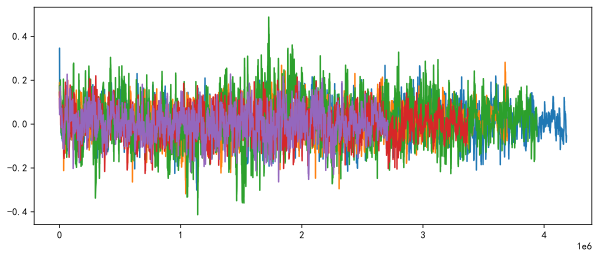

In [22]:
for product in product_list:
    plt.figure(1, figsize=(10, 4))
    plt.plot(all_product_signal[product])

In [23]:
to_choose = (np.arange(n_days)+1) % 10 == 0
## chooose one day out of 10 days
signal_name = "trade.imb.4096"
all_product_signal = dict([])
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"\\pkl_tick\\"+product+"\\"+file)
        S = load(SAVE_PATH+"\\factor_pkl\\"+product+"\\"+signal_name+"\\"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

**画几种品种的因子二的值**

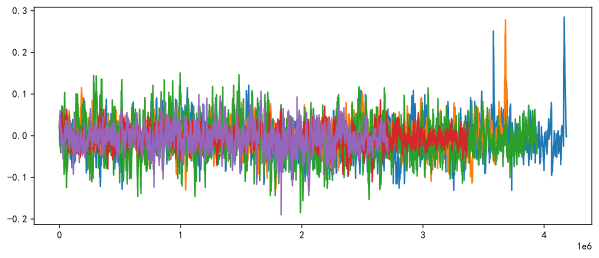

In [24]:
for product in product_list:
    plt.figure(2, figsize=(10,4))
    plt.plot(all_product_signal[product])

因子回测
- open_thre：开仓阈值，close_thre：平仓阈值
- **现在先使用网格优化，未来可能考虑更高效的贝叶斯优化**

In [25]:
# grid of the parameters to be tuned and optimized

from collections import OrderedDict
import itertools
open_list = np.arange(0.05, 0.088, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat

,open,close
0,0.05,-0.010
1,0.05,-0.020
2,0.05,-0.030
3,0.05,-0.040
4,0.05,-0.050
5,0.06,-0.012
6,0.06,-0.024
7,0.06,-0.036
8,0.06,-0.048
9,0.06,-0.060


有个reverse参数，说是1和-1不一样，只有一个可以，另一个不行，未来回归分析的话可以自己调整。这里如果取reverse=1那么效果会很差。相当于是一个反转趋势因子。

In [26]:
%%time
signal_name = "trade.imb.4096"
all_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=1.1e-4, max_spread=spread*1.1, tranct_ratio=True, atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

Wall time: 3min 25s


In [27]:
save(all_trade_stat, HEAD_PATH+"\\processed_data\\"+"black_trade_stat_trade_imb_4096.pkl")

In [28]:
all_trade_stat = load(HEAD_PATH+"\\processed_data\\"+"black_trade_stat_trade_imb_4096.pkl")
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

**统计一下average PNL**

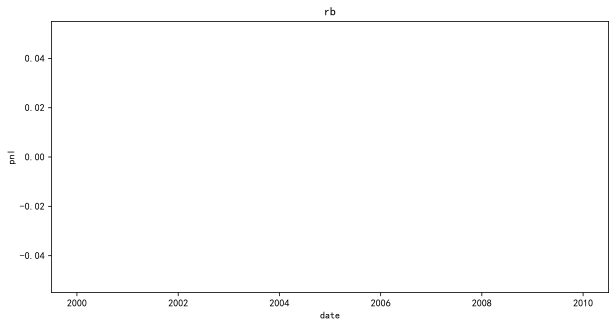

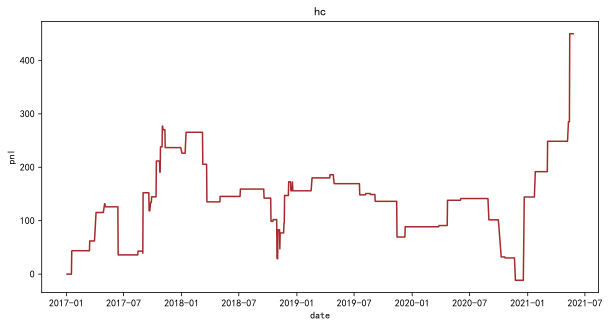

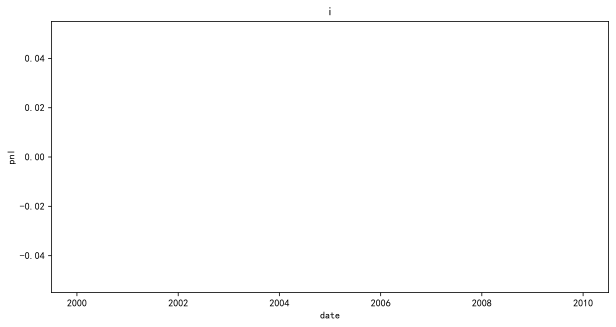

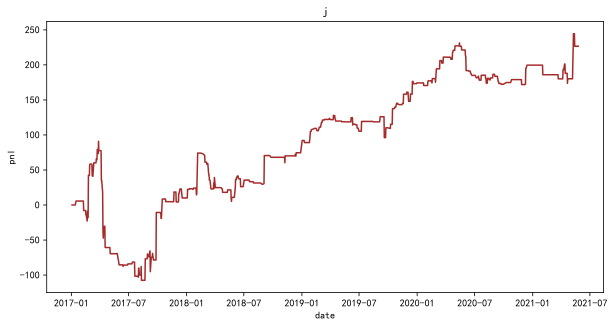

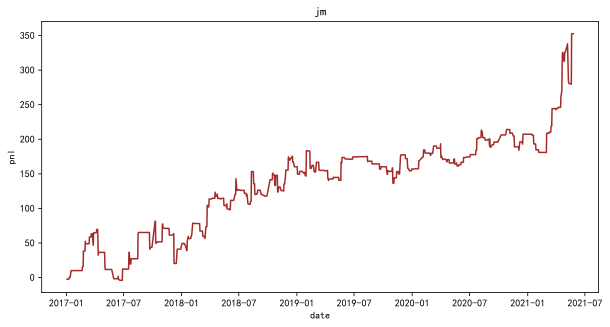

In [29]:
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum(), color='brown')

**划分样本内外，使用训练数据集**

In [30]:
product = "rb"
spread = product_info[product]["spread"]
trade_stat = all_trade_stat[product]
good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
trade_stat["final.result"]

,open,close,num,avg.pnl,total.pnl,sharpe,drawdown,max.drawdown,avg.ret,total.ret,sharpe.ret,drawdown.ret,max.drawdown.ret,mar,mar.ret
0,0.05,-0.010,508,1.313688,667.35356,0.433646,194.38221,337.98962,0.000372,0.189169,0.443692,0.056704,0.100733,1.974479,1.877928
1,0.05,-0.020,500,1.564843,782.42171,0.476048,198.13358,368.54152,0.000458,0.228855,0.499854,0.055442,0.123184,2.123022,1.857834
2,0.05,-0.030,491,1.508047,740.45126,0.428121,268.17072,428.87191,0.000467,0.229485,0.475744,0.076793,0.115162,1.726509,1.992708
3,0.05,-0.040,486,1.068321,519.20413,0.297198,407.75737,543.91617,0.000346,0.168015,0.344819,0.101241,0.138454,0.954566,1.213508
4,0.05,-0.050,484,0.741146,358.71487,0.202147,524.96141,652.57851,0.000256,0.124073,0.250005,0.132985,0.165005,0.549688,0.751937
5,0.06,-0.012,338,1.269510,429.09422,0.342916,252.17153,374.24130,0.000322,0.108771,0.324696,0.070359,0.120721,1.146571,0.901016
6,0.06,-0.024,336,0.721856,242.54358,0.178771,544.75586,623.19855,0.000207,0.069462,0.189833,0.139983,0.163754,0.389192,0.424185
7,0.06,-0.036,334,0.745654,249.04849,0.181203,495.24292,636.62772,0.000210,0.070164,0.189224,0.128952,0.167619,0.391200,0.418594
8,0.06,-0.048,333,0.116371,38.75150,0.027137,602.22939,734.61606,0.000028,0.009196,0.023644,0.158619,0.194944,0.052751,0.047171
9,0.06,-0.060,332,0.109872,36.47739,0.025526,603.49041,741.87598,0.000034,0.011325,0.029179,0.159472,0.197843,0.049169,0.057241


上面的结果用了全部的数据集做的全局面板优化。现在划分训练集和测试集来看一看样本内的调参在样本外的结果

In [31]:
train_sample = np.array(all_dates)<"2019"
sum(train_sample)

487

In [32]:
test_sample = np.array(all_dates)>"2019"
sum(test_sample)

580

In [33]:
%%time
signal_name = "trade.imb.4096"
train_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=1.1e-4, max_spread=spread+0.1, tranct_ratio=True, atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat

Wall time: 2min 1s


In [34]:
save(train_trade_stat, HEAD_PATH+"/black.train_trade_stat.pkl")

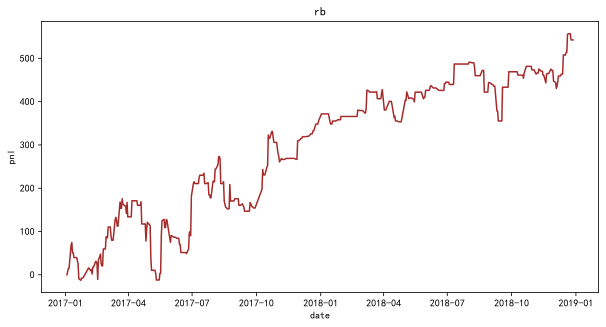

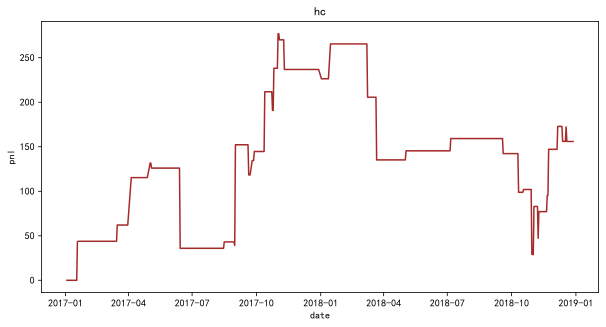

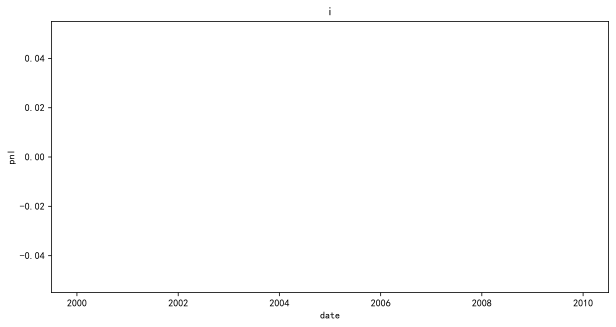

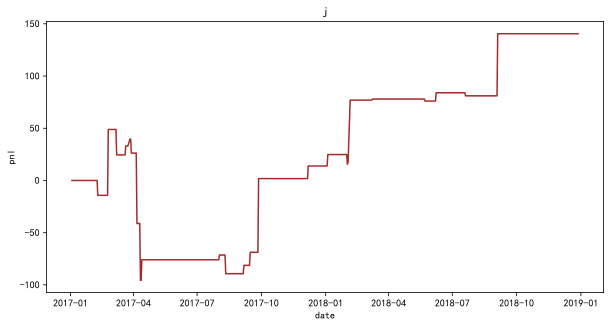

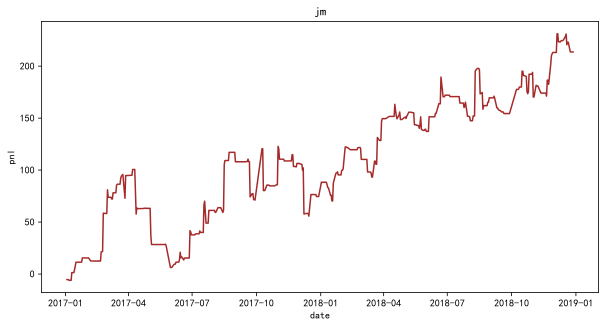

In [45]:
i = 0
train_trade_stat = load(HEAD_PATH+"/black.train_trade_stat.pkl")
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    good_pnl = trade_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    plt.figure(i, figsize=(10, 5))
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[train_sample], good_pnl.cumsum(), color='brown')

In [46]:
%%time
signal_name = "trade.imb.4096"
test_trade_stat = dict([])
for product in product_list:
    spread = product_info[product]["spread"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=-1, tranct=1.1e-4, max_spread=spread+0.1, tranct_ratio=True, atr_filter=0.01)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
    test_trade_stat[product] = trade_stat

Wall time: 1min 53s


In [47]:
save(test_trade_stat, HEAD_PATH+"/black.test_trade_stat.pkl")

rb train sharpe  1.0774599609549398 test sharpe  -0.6178147452051459
hc train sharpe  0.39433008258569435 test sharpe  0.3475823917806401
j train sharpe  0.5464136016228255 test sharpe  -0.035014428338016094
jm train sharpe  0.7472392157724299 test sharpe  0.8558971357860319


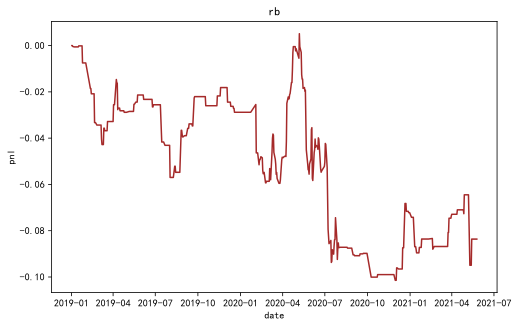

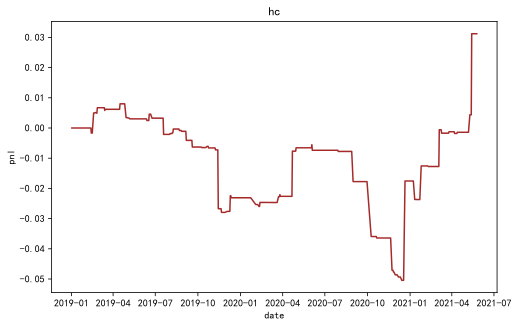

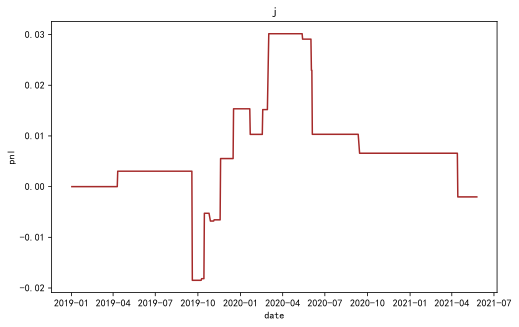

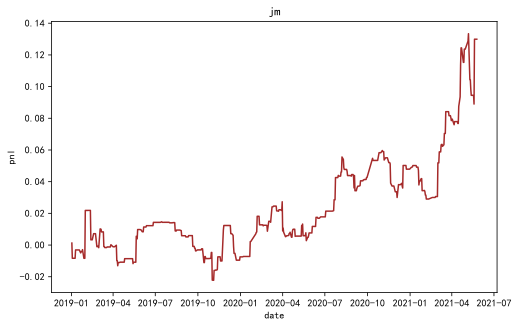

In [48]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>1*spread) & (trade_stat["final.result"]["num"]>20)
    train_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    if sum(good_strat)<2:
        continue
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
    plt.figure(i, figsize=(8, 5))
    plt.title("")
    plt.xlabel("date")
    plt.ylabel("pnl")
    plt.title(product)
    plt.plot(format_dates[test_sample], test_pnl.cumsum(), color='brown')


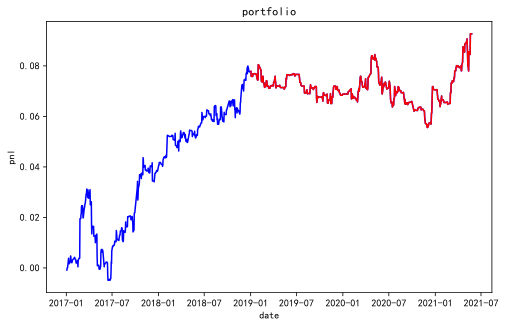

In [49]:
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
all_portfolio
plt.figure(1, figsize=(8, 5))
plt.title("")
plt.xlabel("date")
plt.ylabel("pnl")
plt.title("portfolio")
plt.plot(format_dates, all_portfolio.cumsum(), color='b')
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample], color='r')
    

进一步优化方向：
- 顺势逆势都回测一下试试，也就是reverse=1和-1
- 以上回测只用到了一个因子，可以对total.trade.imb.4096同样测试一下
- 可以把波动率过滤的因子阈值更换为比如20%或其他数值
- 可以更改训练集测试集的划分时间点